## 1.) Business Case: Yulu - Hypothesis Testing

The dataset is of a micro-mobility service provider. The data given indicates the details about all the factors effecting the electric cycles usage.
## Problem Statement definition: 
Yulu has recently suffered considerable dips in its revenues. They have contracted a consulting company to understand the factors on which the demand for these shared electric cycles depends. Specifically, they want to understand the factors affecting the demand for these shared electric cycles in the Indian market.
* Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
* How well those variables describe the electric cycle demands
* datetime: datetime
* season: season (1: spring, 2: summer, 3: fall, 4: winter)
* holiday: whether day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
* workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
* weather:
    * 1: Clear, Few clouds, partly cloudy, partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp: temperature in Celsius
* atemp: feeling temperature in Celsius
* humidity: humidity
* windspeed: wind speed
* casual: count of casual users
* registered: count of registered users
* count: count of total rental bikes including both casual and registered

### Addition Views
* The weather column seems to have integer variables 1,2,3,4 which actually denotes categories and need to considered accordingly
* Would convert int (categories) to String (categories) for better visulization.

In [277]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
from  scipy.stats import ttest_ind,f_oneway,chi2_contingency
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import levene

In [105]:
yulu=pd.read_csv("bike_sharing.csv")

print('Shape of the data set is as follows: ')
print('No. of Rows: '+ str(yulu.shape[0]))
print('No. of Columns: '+ str(yulu.shape[1]))
print('-------------------------------------------')

Shape of the data set is as follows: 
No. of Rows: 10886
No. of Columns: 12
-------------------------------------------


In [106]:
yulu.describe().T  

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


## 2.1 Non-Graphical Analysis: Value counts and unique attributes ​

In [107]:
print("Number of unique values for each column ")
print("------------------------------------------")
for column in list(yulu.columns):
    print(column+ " :  "+ str(yulu[''+column+''].value_counts().nunique()) )

Number of unique values for each column 
------------------------------------------
datetime :  1
season :  3
holiday :  2
workingday :  2
weather :  4
temp :  46
atemp :  53
humidity :  73
windspeed :  26
casual :  86
registered :  69
count :  63


In [108]:
#Values of attributes having 5 or less categories based on the above unique value counts

print("Season unique values : ")
print(yulu['season'].value_counts().index.to_list())
print("-------------------------")

print("Working days uniquwe values ")
print(yulu['workingday'].value_counts().index.to_list())
print("-------------------------")


print("Working day unique values ")
print(yulu['weather'].value_counts().index.to_list())
print("-------------------------")


print("Holiday day unique values ")
print(yulu['holiday'].value_counts().index.to_list())
print("-------------------------")
# print("Stay_In_Current_City_Years unique values ")
# print(walmart_data['Stay_In_Current_City_Years'].value_counts().index.to_list())
# print("-------------------------")



Season unique values : 
[4, 2, 3, 1]
-------------------------
Working days uniquwe values 
[1, 0]
-------------------------
Working day unique values 
[1, 2, 3, 4]
-------------------------
Holiday day unique values 
[0, 1]
-------------------------


### As we see the categorical variables are numeric, we want to convert them to a more readble strings
Comments on range of attributes, outliers of various attribute: 
* season: season (1: spring, 2: summer, 3: fall, 4: winter)
* weather:
    * 1: Clear, Few clouds, partly cloudy -> CLEAR WEATHER
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist -> LIGHT MIST AND FEW CLOUDS
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds -> LIGHT SNOW OR RAIN
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog -> BAD WEATHER
* datetime : Can be split with date leaving time to a different column

In [109]:
yulu.loc[yulu["season"] == 1, "season"]= 'Spring'
yulu.loc[yulu["season"] == 2, "season"]= 'Summer'
yulu.loc[yulu["season"] == 3, "season"]= 'Fall'
yulu.loc[yulu["season"] == 4, "season"]= 'Winter'
yulu

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,Spring,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,Spring,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,Spring,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,Spring,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,Spring,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,Winter,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,Winter,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,Winter,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,Winter,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [151]:
yulu.loc[yulu["weather"] == 1, "weather"]= 'Clear'
yulu.loc[yulu["weather"] == 2, "weather"]= 'Light Mist/clouds'
yulu.loc[yulu["weather"] == 3, "weather"]= 'Light snow/rain'
yulu.loc[yulu["weather"] == 4, "weather"]= 'Bad Weather'


In [169]:
yulu["date"] = pd.to_datetime(yulu["datetime"]).dt.date
yulu

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0000,3,13,16,2011-01-01
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0000,8,32,40,2011-01-01
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0000,5,27,32,2011-01-01
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0000,3,10,13,2011-01-01
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0000,0,1,1,2011-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,Winter,0,1,Clear,15.58,19.695,50,26.0027,7,329,336,2012-12-19
10882,2012-12-19 20:00:00,Winter,0,1,Clear,14.76,17.425,57,15.0013,10,231,241,2012-12-19
10883,2012-12-19 21:00:00,Winter,0,1,Clear,13.94,15.910,61,15.0013,4,164,168,2012-12-19
10884,2012-12-19 22:00:00,Winter,0,1,Clear,13.94,17.425,61,6.0032,12,117,129,2012-12-19


In [180]:
print("Date unique values ")
print(yulu['date'].nunique())
print("-------------------------")

Date unique values 
456
-------------------------


* We have data of 456 days of yulu rides

## 3. Visual Analysis - Univariate & Bivariate
### 3.1 For continuous variable(s): Distplot, countplot, histogram for univariate analysis
* Would keep it short and simple and to the metrics that matter

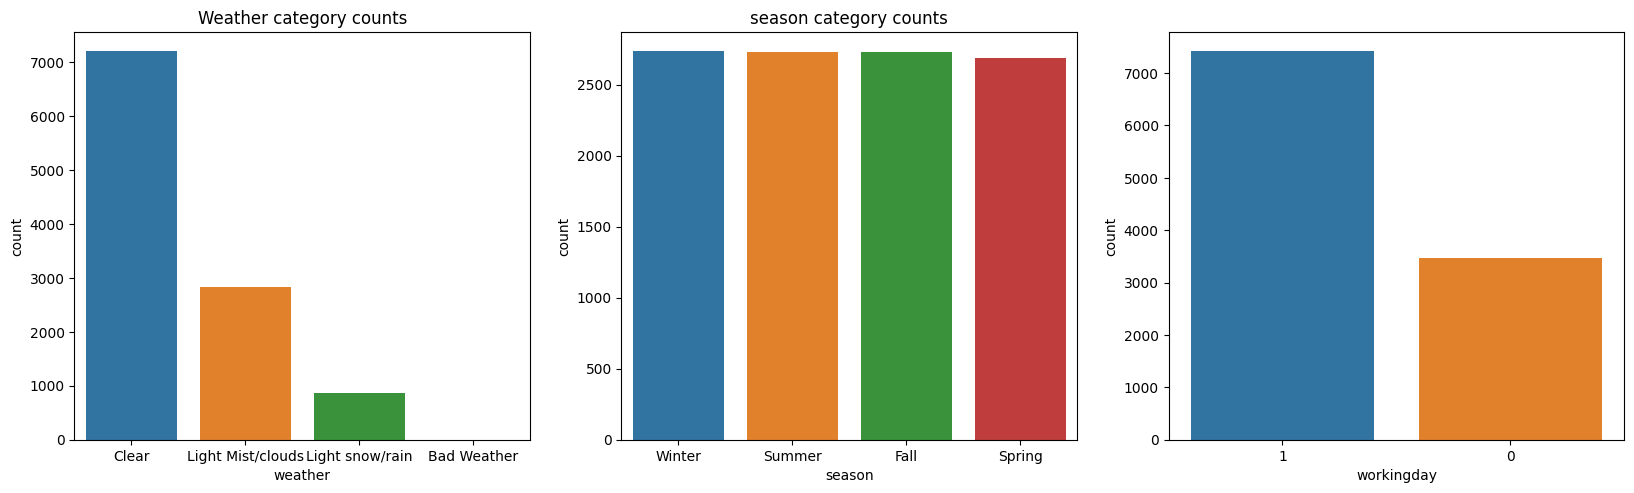

In [185]:

# Countplot of categorical variables

fig = plt.figure(figsize=[20,18])

plt.subplot(3,3,1)
sns.countplot(data=yulu,x='weather')
plt.title("Weather category counts")

plt.subplot(3,3,2)
sns.countplot(data=yulu,x='season',order=yulu['season'].value_counts().sort_values(ascending=False).index)
plt.title("season category counts")

plt.subplot(3,3,3)
sns.countplot(data=yulu,x='workingday',order=yulu['workingday'].value_counts().sort_values(ascending=False).index)


plt.show()




## Observations
* We see we have evenly seasonalized data. 
* Also most of the data from the sample, we have more of working days.
* We see from the sample bad weather is not being counted.

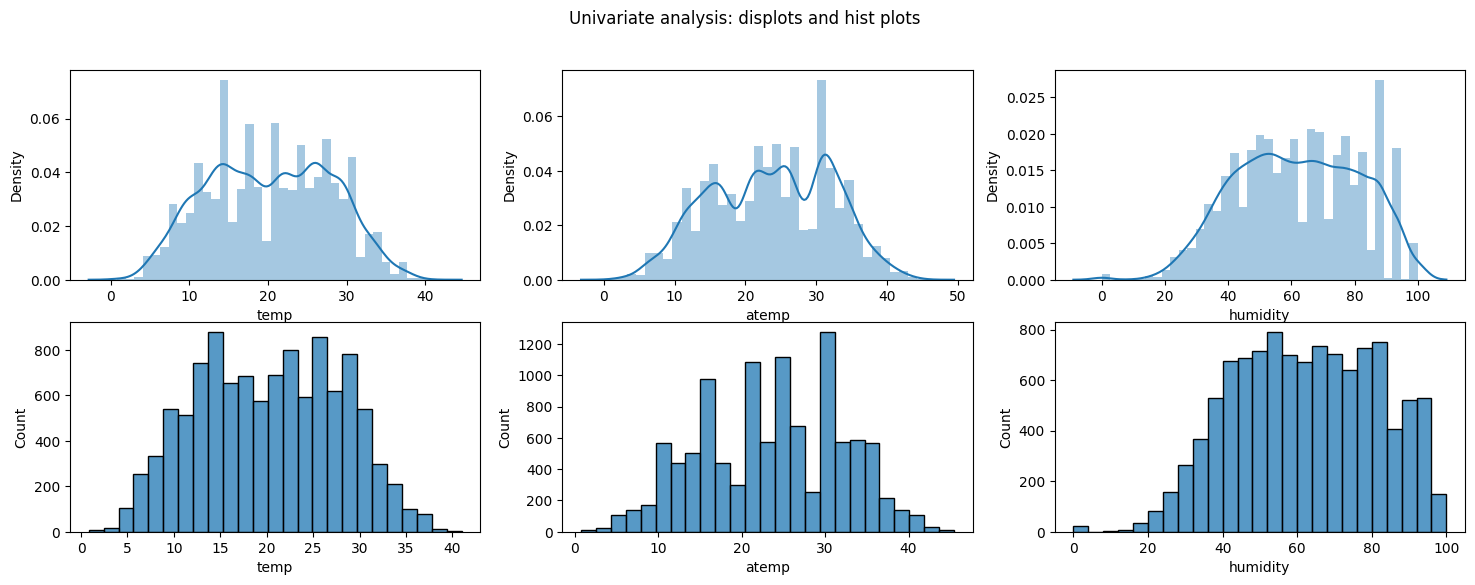

In [200]:
fig= plt.figure(figsize=(18,6))
fig.suptitle("Univariate analysis: displots and hist plots")
plt.subplot(2,3,1)
sns.distplot(yulu["temp"])
plt.subplot(2,3,4)
sns.histplot(x='temp',data = yulu,bins=25)


plt.subplot(2,3,2)
sns.distplot(yulu["atemp"])
plt.subplot(2,3,5)
sns.histplot(x='atemp',data = yulu,bins=25)


plt.subplot(2,3,3)
sns.distplot(yulu["humidity"])
plt.subplot(2,3,6)
sns.histplot(x='humidity',data = yulu,bins=25)



plt.show()


In [208]:
yulu.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'date'],
      dtype='object')

### BIVARIATE


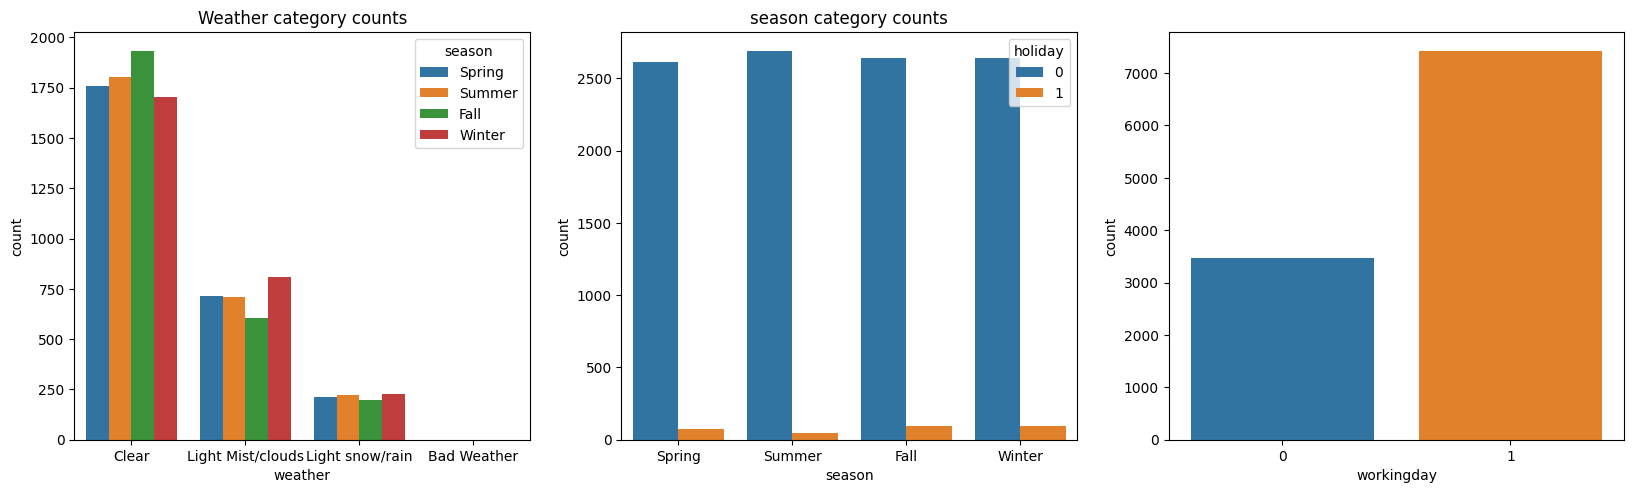

In [223]:

# Countplot of categorical variables

fig = plt.figure(figsize=[20,18])

plt.subplot(3,3,1)
sns.countplot(data=yulu,x='weather',hue="season")
plt.title("Weather category counts")

plt.subplot(3,3,2)
sns.countplot(data=yulu,x='season',hue="holiday")
plt.title("season category counts")

plt.subplot(3,3,3)
sns.countplot(data=yulu,x='workingday')


plt.show()




 BIVARIATE (workday and count, season and count, weather and count.)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


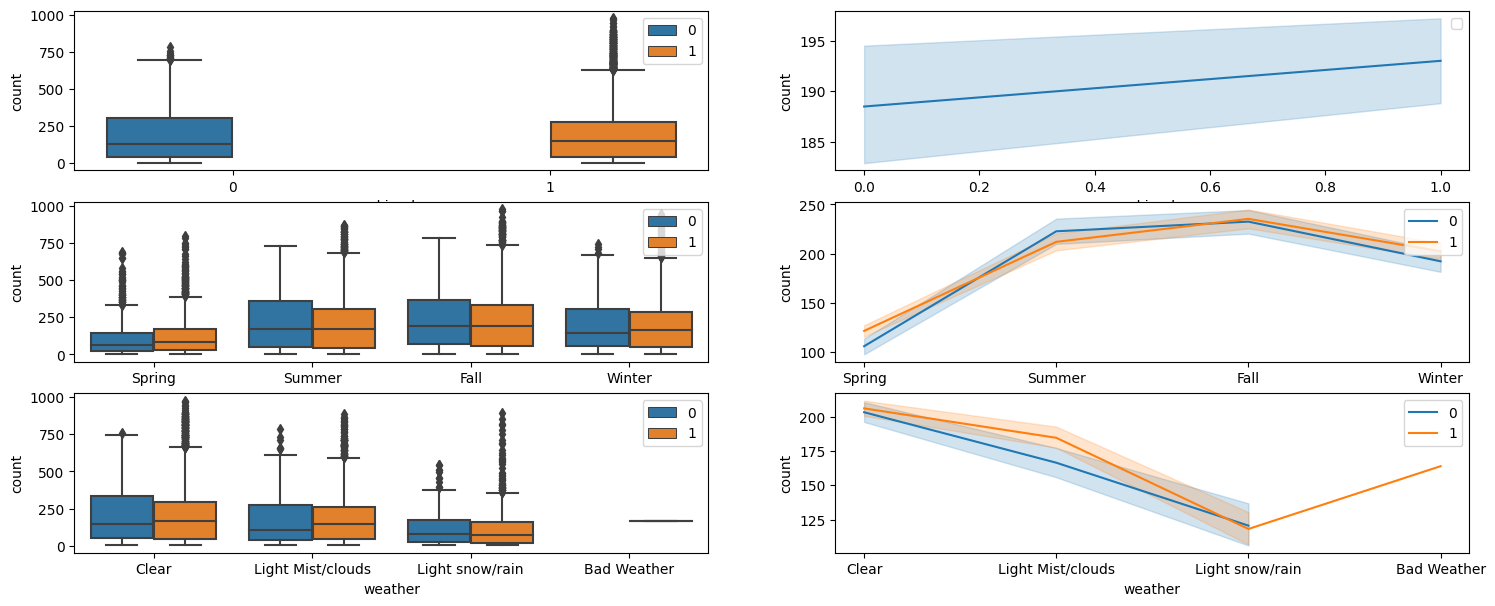

In [217]:
fig= plt.figure(figsize=(18,12))

plt.subplot(5,2,1)
sns.boxplot(x='workingday',y='count',data=yulu,hue='workingday')
plt.legend(loc='upper right')
plt.subplot(5,2,2)
sns.lineplot(data=yulu, x='workingday',y='count')
plt.legend(loc='upper right')

plt.subplot(5,2,3)
sns.boxplot(x='season',y='count',hue='workingday',data=yulu)
plt.legend(loc='upper right')

plt.subplot(5,2,4)
sns.lineplot(data=yulu, x='season',y='count',hue = 'workingday')
plt.legend(loc='upper right')

plt.subplot(5,2,5)
sns.boxplot(x='weather',y='count',hue='workingday',data=yulu)
plt.legend(loc='upper right')

plt.subplot(5,2,6)
sns.lineplot(data=yulu, x='weather',y='count',hue = 'workingday')
plt.legend(loc='upper right')



plt.show()




### Observations
* As we see the yulu rents peak at fall and reduce at winter irrespective of it being a working day
* Clear weather and light mist/clouds are th best time for peak rentals, 
* light rain/snow and bad weather are bad for yuly cycle rentals

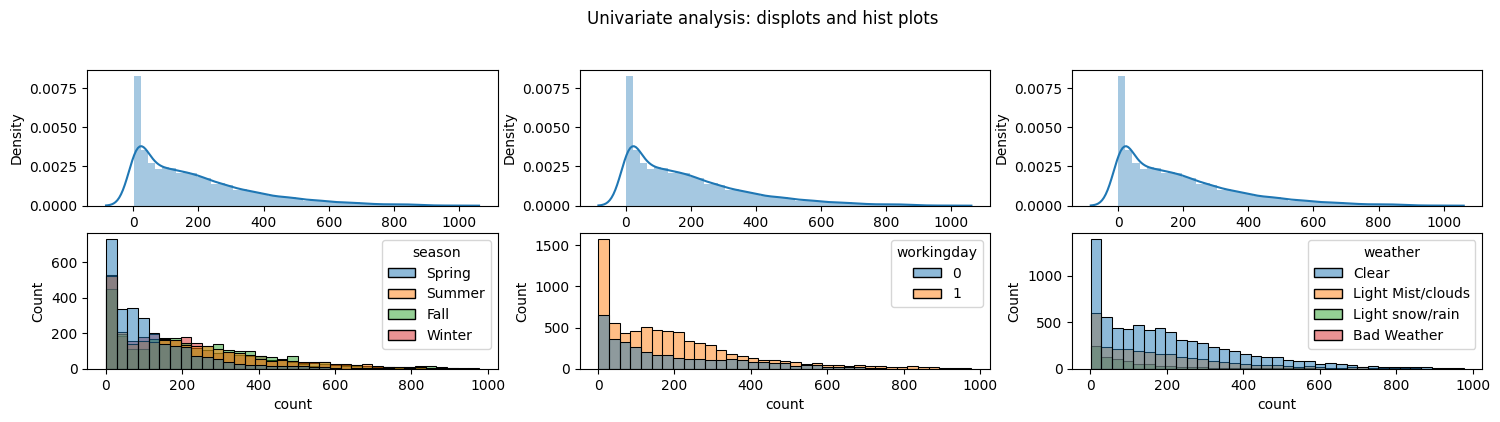

In [285]:
# Countplot of categorical variables bivariate
fig= plt.figure(figsize=(18,6))
fig.suptitle("Univariate analysis: displots and hist plots")
plt.subplot(3,3,1)
sns.distplot(yulu["count"])
plt.subplot(3,3,4)
sns.histplot(x='count',data = yulu,hue='season',bins=35)


plt.subplot(3,3,2)
sns.distplot(yulu["count"])
plt.subplot(3,3,5)
sns.histplot(x='count',data = yulu,hue='workingday',bins=35)


plt.subplot(3,3,3)
sns.distplot(yulu["count"])
plt.subplot(3,3,6)
sns.histplot(x='count',data = yulu,hue='weather',bins=35)



plt.show()


### OBSERVATONS
* As we see in clear weather has maximum rentals
* Working days are good day for cycle rentals too
* Spring and summer seems to have highest counts


## Hypothesis Testing

1. To check if Working Day has an effect on the number of electric cycles rente

* H0 : Working day has "NO" effect on number of electric cycles
* Ha : Working day "HAS" an effect on number of electric cycles

In [231]:
# Converting the data into two groups

# Workingday = 1 (Yes it's a working day)
Working_day_rentals = yulu[yulu["workingday"] == 1]
# Workingday = 0 (No it's not a working day)
Non_Working_day_rentals = yulu[yulu["workingday"] == 0]

print("Working day rental count : " +str(Working_day_rentals["workingday"].count()))
Non_Working_day_rentals.count()
print("Non Working day rental count : " +str(Non_Working_day_rentals["workingday"].count()))

Working day rental count : 7412
Non Working day rental count : 3474


### Since Working day has only 2 categories - Yes and No

We can use T_test independednt as we see both of the ctaegories are mutually exclusive
Assumptions to use T_test
* The data are continuous.(counts of rental bikes are a continuous variable)
* The sample data have been randomly sampled from a population. (This is assumed since we don't know the source of the data)
* There is homogeneity of variance (i.e., the variability of the data in each group is similar ). (Will be verified below with levene test)
* The distribution is approximately normal. (qq-plot)

## qq-plots

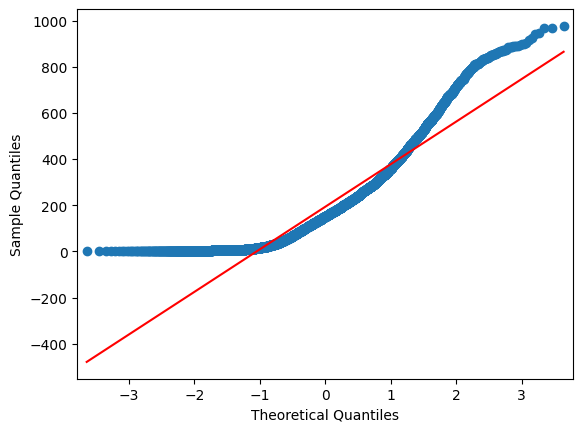

In [273]:
qqplot(Working_day_rentals["count"], line = "s")
plt.show()

Testing distribution with statistical methods like levene’s test, Shapiro-wilk test

## Shapiro test

In [276]:
# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(yulu["count"])

# Print the results
print("Shapiro-Wilk Test Statistic:", statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value > alpha:
    print("The data follows a normal distribution (fail to reject H0)")
else:
    print("The data does not follow a normal distribution (reject H0)")


Shapiro-Wilk Test Statistic: 0.878369927406311
p-value: 0.0
The data does not follow a normal distribution (reject H0)


## Levine test

In [278]:
# Perform the Levine test
statistic, p_value = levene(Working_day_rentals["count"],Non_Working_day_rentals["count"])

# Print the results
print("Levine Test Statistic:", statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value > alpha:
    print("The variances are equal (fail to reject H0)")
else:
    print("The variances are not equal (reject H0)")


Levine Test Statistic: 0.004972848886504472
p-value: 0.9437823280916695
The variances are equal (fail to reject H0)


### Observations
* Levene test stats the varianes are equal between the groups of working day and non working day
* Shapiro and qq-plot states the data isn't normal but we'll assume it to be for futher analysis

# Visual verification of the distribution

<Axes: xlabel='count', ylabel='Count'>

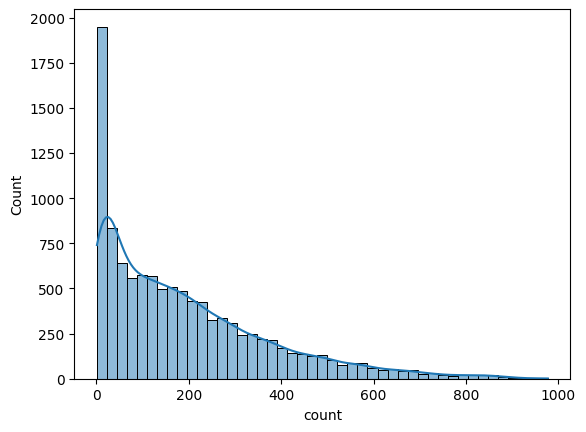

In [287]:
# np.log(number)
sns.histplot(yulu["count"], kde = True)

## T-Test

In [249]:
# Let's say alpha is 0.5
t_test , p_value = ttest_ind(Working_day_rentals["count"],Non_Working_day_rentals["count"])

if p_value<0.05:
    print('Reject H0 -> Working day "HAS" an effect on number of electric cycles')
else:
    print('Failed to reject null hypothesis ->  Working day has "NO" effect on number of electric cycles ')

Failed to reject null hypothesis ->  Working day has "NO" effect on number of electric cycles 


Observation clearly not normal

## ANOVA TEST (Seasons, weather) -> more than one categories 

As we see there are 4 categories
* Spring
* Summer
* Fall
* Winter


No. of cycles rented similar or different in different seasons
* season: season (1: spring, 2: summer, 3: fall, 4: winter)

#### Hypothesis (Null and Alternate)
* H0 : Renatls of yulu cycles have "NO" effect with chnaging seasons
* Ha : Rentals of yulu cycles "HAVE" effect with changing seasons

In [256]:
Rentals_spring = yulu[yulu["season"] == "Spring"]["count"]
Rentals_summer = yulu[yulu["season"] == "Summer"]["count"]
Rentals_fall = yulu[yulu["season"] == "Fall"]["count"]
Rentals_winter = yulu[yulu["season"] == "Winter"]["count"]

x_stat,p_value=f_oneway(Rentals_spring,Rentals_summer,Rentals_fall,Rentals_winter) # p-value is fairly low

if p_value < 0.05:
    print('Reject H0 : Rentals of yulu cycles "HAVE" effect with changing seasons')
else:
    print('Failed to Reject H0 Rentals of yulu cycles have "NO" effect with changing seasons')
    

Reject H0 : Rentals of yulu cycles "HAVE" effect with changing seasons


In [290]:
Rentals_spring = yulu[yulu["season"] == "Spring"]["atemp"]
Rentals_summer = yulu[yulu["season"] == "Summer"]["atemp"]
Rentals_fall = yulu[yulu["season"] == "Fall"]["atemp"]
Rentals_winter = yulu[yulu["season"] == "Winter"]["atemp"]

x_stat,p_value=f_oneway(Rentals_spring,Rentals_summer,Rentals_fall,Rentals_winter) # p-value is fairly low

if p_value < 0.05:
    print('Reject H0 : Perceived Temperature "HAVE" effect with changing season')
else:
    print('Failed to Reject H0 Perceived Temperature have "NO" effect with changing seasons')
    

Reject H0 : Perceived Temperature "HAVE" effect with changing season


In [291]:
Rentals_spring = yulu[yulu["season"] == "Spring"]["atemp"]
Rentals_summer = yulu[yulu["season"] == "Summer"]["atemp"]
Rentals_fall = yulu[yulu["season"] == "Fall"]["atemp"]
Rentals_winter = yulu[yulu["season"] == "Winter"]["atemp"]

x_stat,p_value=f_oneway(Rentals_spring,Rentals_summer,Rentals_fall,Rentals_winter) # p-value is fairly low

if p_value < 0.05:
    print('Reject H0 : Perceived Temperature "HAVE" effect with changing season')
else:
    print('Failed to Reject H0 Perceived Temperature have "NO" effect with changing seasons')
    

Reject H0 : Perceived Temperature "HAVE" effect with changing season


In [292]:
Rentals_spring = yulu[yulu["season"] == "Spring"]["windspeed"]
Rentals_summer = yulu[yulu["season"] == "Summer"]["windspeed"]
Rentals_fall = yulu[yulu["season"] == "Fall"]["windspeed"]
Rentals_winter = yulu[yulu["season"] == "Winter"]["windspeed"]

x_stat,p_value=f_oneway(Rentals_spring,Rentals_summer,Rentals_fall,Rentals_winter) # p-value is fairly low

if p_value < 0.05:
    print('Reject H0 :Windspeed "HAVE" effect with changing season')
else:
    print('Failed to Reject H0 Windspeed have "NO" effect with changing seasons')
    

Reject H0 :Windspeed "HAVE" effect with changing season


In [258]:
Rentals_clear_weather = yulu[yulu["weather"] == "Clear"]["count"]
Rentals_light_weather = yulu[yulu["weather"] == "Light Mist/clouds"]["count"]
Rentals_snow_rain_weather = yulu[yulu["weather"] == "Light snow/rain"]["count"]
Rentals_bad_weather = yulu[yulu["weather"] == "Bad Weather"]["count"]

x_stat,p_value=f_oneway(Rentals_clear_weather,Rentals_light_weather,Rentals_snow_rain_weather,Rentals_bad_weather) 

if p_value < 0.05:
    print('Reject H0 : Rentals of yulu cycles "HAVE" effect with changing weather')
else:
    print('Failed to Reject H0 Rentals of yulu cycles have "NO" effect with changing weather')
    

Reject H0 : Rentals of yulu cycles "HAVE" effect with changing weather


## Chi-square test to check if Weather is dependent on the season 

In [264]:
weather_rentals = pd.crosstab(index=yulu['weather'],columns=yulu['season'])
weather_rentals

season,Fall,Spring,Summer,Winter
weather,,,,
Bad Weather,0,1,0,0
Clear,1930,1759,1801,1702
Light Mist/clouds,604,715,708,807
Light snow/rain,199,211,224,225


* H0: Weather and season are independent
* Ha: Weather and season are dependent

In [286]:
# H0: Weather and season are independent
# Ha: Weather and season are dependent

chi_stat, p_value, df, exp_value = chi2_contingency(weather_rentals)
print("exp_value: " + str(exp_value )+"\n")
print("p_value: " + str(p_value ))
print("df: " + str(df ))
print("chi_stat: " + str(chi_stat ))

exp_value: [[2.51056403e-01 2.46738931e-01 2.51056403e-01 2.51148264e-01]
 [1.80559765e+03 1.77454639e+03 1.80559765e+03 1.80625831e+03]
 [7.11493845e+02 6.99258130e+02 7.11493845e+02 7.11754180e+02]
 [2.15657450e+02 2.11948742e+02 2.15657450e+02 2.15736359e+02]]

p_value: 1.5499250736864862e-07
df: 9
chi_stat: 49.15865559689363


In [281]:
print("Conclusion: ")
if p_value < 0.05:
    print("Reject H0")
    print("Weather impacts season")
else:
    print("Failed to reject null hypotheis")
    print("Weather does not impact season")

Conclusion: 
Failed to reject null hypotheis
Weather does not impact season


CONCLUSION AND INFERENCES
* From hypothesis testing with a alpha = 5% we have seen the following
    * Weather does not impact the season
    * Temperature "HAVE" effect with changing season
    * Rentals of yulu cycles "HAVE" effect with changing weather
    * Rentals of yulu cycles "HAVE" effect with changing seasons
    * Working day has "NO" effect on number of electric cycles 

## Insights and recommendations


* Weather Impact: Since weather has a significant effect on Yulu cycle rentals, the company can target areas with more consistent and favorable weather conditions. Locations with milder climates or longer periods of pleasant weather may witness higher demand for bike rentals throughout the year.

* Seasonal Variation: As rentals of Yulu cycles are impacted by changing seasons, the company can strategize its marketing and promotional efforts accordingly. During peak seasons, such as summer or holidays, they can increase their fleet and promote special offers to attract more customers.

* Working Days: Since working days have no significant effect on the number of electric cycle rentals, the company may not need to invest heavily in marketing efforts during weekdays. Instead, they can concentrate their promotional activities on weekends and holidays when demand is expected to be higher.

* Yulu can leverage data analytics to identify specific areas and neighborhoods where there is a higher demand for bike rentals. They can use historical rental data, weather patterns, and seasonal trends to pinpoint locations where potential customers are likely to use their services

* Seasonal Offers: To capitalize on seasonal variations, Yulu can introduce special promotions, discounts, or loyalty programs during off-peak seasons to encourage customers to rent bikes even when the demand is relatively low.